## Importing Libraries

In [729]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, plot_roc_curve

import shap

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Loading data

In [872]:
df_train = pd.read_excel('train_file.xlsx', engine='openpyxl')
df_test = pd.read_excel('test_file.xlsx', engine='openpyxl')

## Performing EDA

In [873]:
df_train.describe()

,age,duration,campaign,previous
count,32910.000000,32910.000000,32910.000000,32910.000000
mean,40.014099,258.164327,2.560620,0.174810
std,10.402948,259.070260,2.753336,0.499211
min,17.000000,0.000000,1.000000,0.000000
25%,32.000000,103.000000,1.000000,0.000000
50%,38.000000,180.000000,2.000000,0.000000
75%,47.000000,319.000000,3.000000,0.000000
max,98.000000,4918.000000,56.000000,7.000000


In [874]:
df_train.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,32910,32910,32910,32910,32910,32910,32910,32910,32910,32910,32910
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,8305,19929,9727,25975,17236,27099,20890,10993,6849,28380,29203


**Removing duplicates**: there were 8 duplicated rows

In [875]:
df_train = df_train.drop_duplicates().reset_index(drop=True)

**Checking possible correlated numerical features for feature selection**

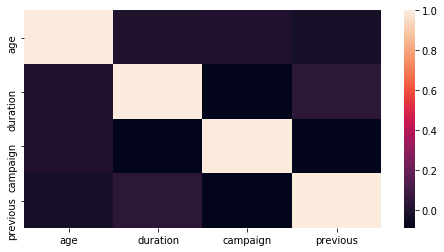

In [876]:
corr = df_train.corr(method='spearman')
fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(corr)

**Checking possible outliers on numerical features**: the outliers were not removed or changed as they were all still possible values even if distant from the average

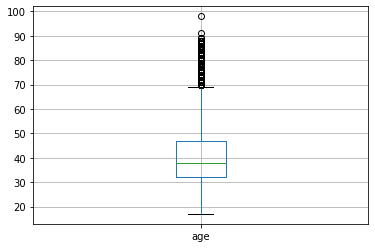

In [877]:
df_train.boxplot(['age'])

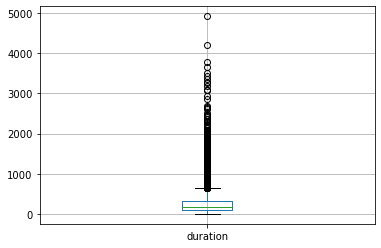

In [878]:
df_train.boxplot(['duration'])

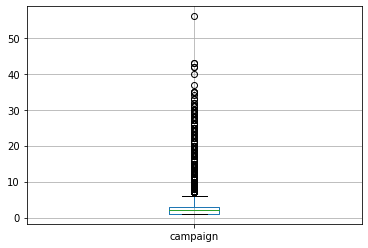

In [879]:
df_train.boxplot(['campaign'])

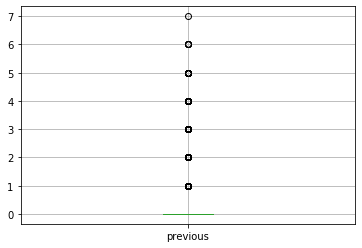

In [880]:
df_train.boxplot(['previous'])

**Checking null values**: there are no null values

In [881]:
df_train.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
previous       0
poutcome       0
y              0
dtype: int64

**Detecting class imbalance**

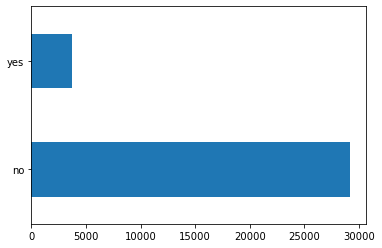

In [882]:
df_train['y'].value_counts().plot(kind='barh')

In [883]:
df_train['y'].value_counts()

no     29195
yes     3707
Name: y, dtype: int64

## Data preparation

Replacing "yes" and "no" string values with 1 and 0 on target column

In [884]:
df_train['y'].replace('yes', 1, inplace=True)
df_train['y'].replace('no', 0, inplace=True)

**Train test split**

In [885]:
X_, X_test_, y_, y_test_ = train_test_split(df_train[[col for col in df_train.columns if col != 'y']], df_train['y'], test_size = 0.2, random_state = 42)

**Target encoding**

In [886]:
df_train_ = pd.concat([X_, y_], axis=1).rename(columns={"0": "y"})

In [887]:
df_val_ = pd.concat([X_test_, y_test_], axis=1).rename(columns={"0": "y"})

In [888]:
df_train_features = pd.DataFrame()
df_val_features = pd.DataFrame()
df_test_features = pd.DataFrame()

te_features_cols = [col for col in df_train.columns if col not in ["age", "duration", "campaign", "previous", "y"]]

for col in te_features_cols:
    means = df_train_[[col, 'y']].groupby(col).mean().reset_index()
    keys = means[col]
    values = means.y
    mapper = {keys[i]: values[i] for i in range(len(keys))}
    print(mapper)
    df_train_features['te_'+col] = df_train_[col].map(mapper)
    df_val_features['te_'+col] = df_val_[col].map(mapper)
    df_test_features['te_'+col] = df_test[col].map(mapper)
    
X = pd.concat([df_train_[[col for col in df_train_.columns if col not in te_features_cols+['y']] ], df_train_features], axis=1)
y = df_train_['y']

X_test = pd.concat([df_test_[[col for col in df_val_.columns if col not in te_features_cols+['y']] ], df_val_features], axis=1)
y_test = df_val_['y']

df_test_te = pd.concat([df_test[[col for col in df_test.columns if col not in te_features_cols ] ], df_test_features], axis=1)

{'admin.': 0.12748344370860928, 'blue-collar': 0.06948183041722746, 'entrepreneur': 0.07601713062098502, 'housemaid': 0.09259259259259259, 'management': 0.11451187335092348, 'retired': 0.2667910447761194, 'self-employed': 0.11355735805330243, 'services': 0.08036064288514308, 'student': 0.29609929078014185, 'technician': 0.10835841630006945, 'unemployed': 0.14705882352941177, 'unknown': 0.12217194570135746}
{'divorced': 0.10101351351351351, 'married': 0.10177685690965028, 'single': 0.13900555480287224, 'unknown': 0.1509433962264151}
{'basic.4y': 0.10449438202247191, 'basic.6y': 0.08544726301735647, 'basic.9y': 0.07638164754953077, 'high.school': 0.10651670525967581, 'illiterate': 0.08333333333333333, 'professional.course': 0.113033104682374, 'university.degree': 0.13620578778135048, 'unknown': 0.15119363395225463}
{'no': 0.12852951079898023, 'unknown': 0.050994575045207956, 'yes': 0.0}
{'no': 0.10924510874128811, 'unknown': 0.10509554140127389, 'yes': 0.11513348810214742}
{'no': 0.11204

**Correlation between features and label**

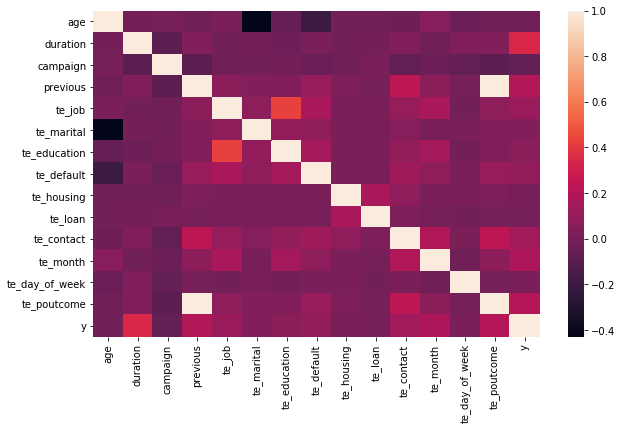

In [746]:
corr = pd.concat([X, y],axis=1).corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(corr)

FEATURE-LABEL correlation
- duration is the most correlated to target: as it is clear from following feature importance
- other features correlated with label are te_poutcome and te_month

FEATURE-FEATURE correlation
- previous is correlated with te_poutcome: looking at the data this is due to the fact that previous is mostly populated with 0 and the related value of te_poutcome is always nonexistent when previous is 0
- education and job are also correlated
- anticorrelated features: marital-age and default-age

Tests were performed removing te_job  and te_marital, but the xgboost model roc_auc did not improve.

In [747]:
# Scaling the features which are not in the target encoding did not improve the roc_auc of the models
# scaler = StandardScaler()
# df_train_features = scaler.fit_transform(df_train_features)

**Under sampling**

In [748]:
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=42)
X_under, y_under = rus.fit_resample(X, y)

## Modeling and Eval - Random Forest

Model was fit on both normal and undersampled data

In [766]:
# Fit model on train data
rf = RandomForestClassifier(random_state=42).fit(X, y)

Precision:0.646
Recall:0.420
F1-score:0.509
roc_auc_score:0.9250913299444636
pr_auc_score:0.5958984129707294


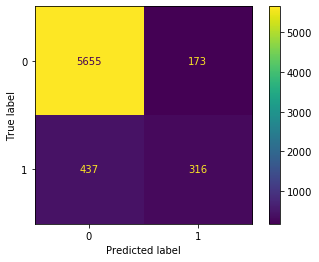

In [767]:
# Predict on test data and evaluate results
rf_predicted = rf.predict(X_test)

cm = confusion_matrix(y_test, rf_predicted, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

print('Precision:{0:.3f}'.format(precision_score(y_test, rf_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, rf_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, rf_predicted)))

print('roc_auc_score:{}'.format(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])))

In [768]:
# Fit model on train data undersampled
rf_under = RandomForestClassifier(random_state=42).fit(X_under, y_under)

Precision:0.583
Recall:0.572
F1-score:0.578
roc_auc_score:0.9263390273269767
pr_auc_score:0.5929118895408895


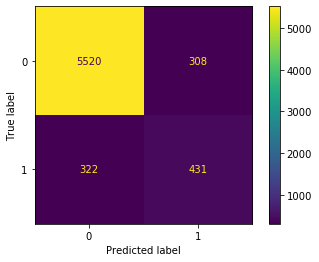

In [769]:
# Predict on test data and evaluate results
rf_predicted = rf_under.predict(X_test)

cm = confusion_matrix(y_test, rf_predicted, labels=rf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_under.classes_)
disp.plot()

print('Precision:{0:.3f}'.format(precision_score(y_test, rf_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, rf_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, rf_predicted)))

print('roc_auc_score:{}'.format(roc_auc_score(y_test, rf_under.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, rf_under.predict_proba(X_test)[:, 1])))

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


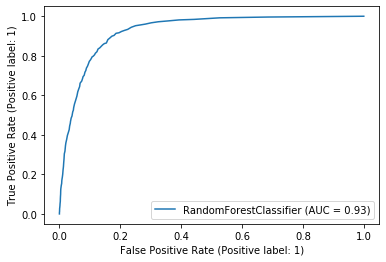

In [756]:
# Plotting ROC curve - model was fit on undersampled data
plot_roc_curve(rf_under, X_test, y_test) 

#### Feature importance with permutation importance - (using undersampled training set)

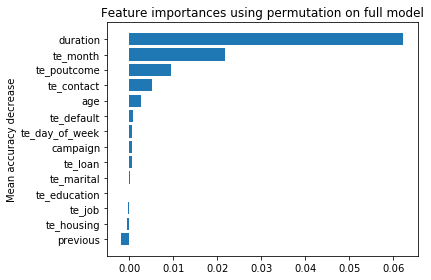

In [941]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    rf_under, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

From the above graph, the most important features are: duration, te_poutcome, te_month, te_contact, age

## Parameter tuning on Random Forest

In [938]:
# Defining parameters to be tuned on randomized search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [849]:
# Intantiate a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate random search using above defined parameters and fit
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_under, y_under)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [850]:
# Best model parameteres
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

Precision:0.594
Recall:0.599
F1-score:0.597
roc_auc_score:0.9306450701426735
pr_auc_score:0.61684733428119


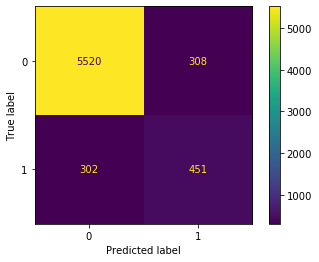

In [851]:
# Evaluation of best model: metrics improved compared to the base model

rf_predicted = rf_random.predict(X_test)

cm = confusion_matrix(y_test, rf_predicted, labels=rf_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_random.classes_)
disp.plot()

print('Precision:{0:.3f}'.format(precision_score(y_test, rf_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, rf_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, rf_predicted)))

print('roc_auc_score:{}'.format(roc_auc_score(y_test, rf_random.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, rf_random.predict_proba(X_test)[:, 1])))

In [856]:
# Trying to fine tune the model with grid search

# Defining parameters to be tuned based on previous randomized search
param_grid = {
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1200, 1400, 1600, 1800]
}

# Intantiate a base model
rf = RandomForestClassifier(random_state=42, max_features='auto', max_depth = None, bootstrap=True)

# Instantiate the grid search model and fit
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_under, y_under)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [1200, 1400, 1600, 1800]},
             verbose=2)

In [857]:
# Best model parameteres 
grid_search.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1800}

Precision:0.597
Recall:0.599
F1-score:0.598
roc_auc_score:0.9303044058039178
pr_auc_score:0.6153192414225065


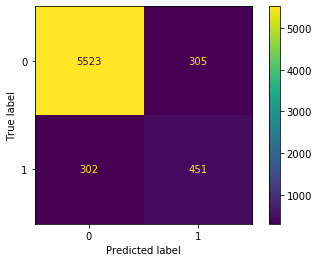

In [858]:
# Evaluation of best model: metrics did not improve compared to random search

rf_predicted = grid_search.predict(X_test)

cm = confusion_matrix(y_test, rf_predicted, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()

print('Precision:{0:.3f}'.format(precision_score(y_test, rf_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, rf_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, rf_predicted)))

print('roc_auc_score:{}'.format(roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, grid_search.predict_proba(X_test)[:, 1])))

## Modeling and Eval - Logistic regression

Model was fit on both normal and undersampled data

In [770]:
# Fit model on train data
lr = LogisticRegression(max_iter=5000, random_state=42).fit(X, y)

Precision:0.685
Recall:0.344
F1-score:0.458
roc_auc_score:0.9165618468701264
pr_auc_score:0.5675282754249458


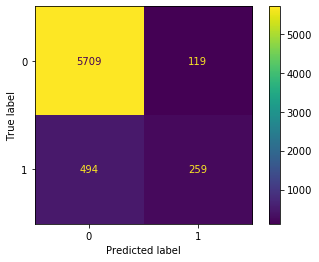

In [771]:
# Predict on test data and evaluate results
lr_predicted = lr.predict(X_test)

cm = confusion_matrix(y_test, lr_predicted, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

print('Precision:{0:.3f}'.format(precision_score(y_test, lr_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, lr_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, lr_predicted)))
print('roc_auc_score:{}'.format(roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, lr.predict_proba(X_test)[:, 1])))

In [772]:
# Fit model on train data undersampled
lr_under = LogisticRegression(max_iter=5000, random_state=42).fit(X_under, y_under)

Precision:0.639
Recall:0.469
F1-score:0.541
roc_auc_score:0.916589191164876
pr_auc_score:0.566909536590391


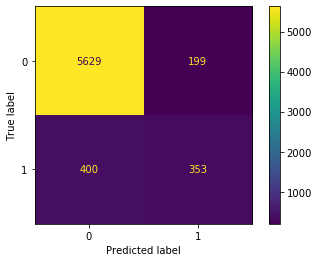

In [773]:
# Predict on test data and evaluate results
lr_predicted = lr_under.predict(X_test)

cm = confusion_matrix(y_test, lr_predicted, labels=lr_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_under.classes_)
disp.plot()

print('Precision:{0:.3f}'.format(precision_score(y_test, lr_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, lr_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, lr_predicted)))
print('roc_auc_score:{}'.format(roc_auc_score(y_test, lr_under.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, lr_under.predict_proba(X_test)[:, 1])))

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


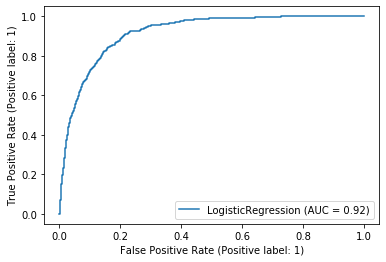

In [763]:
# Plotting ROC curve - model was fit on undersampled data
plot_roc_curve(lr, X_test, y_test)

## Modeling and Eval - XGBoost

Model was fit on both normal and undersampled data

In [774]:
# Fit model on train data
xgbcl = xgb.XGBClassifier(objective= 'binary:logistic', use_label_encoder=False).fit(X, y)

[00:20:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Precision:0.636
Recall:0.452
F1-score:0.528
roc_auc_score:0.9250440471014592
pr_auc_score:0.5865196729916714


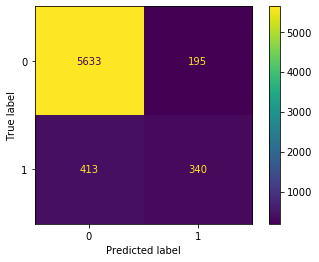

In [775]:
# Predict on test data and evaluate results
xgbcl_predicted = xgbcl.predict(X_test)

cm = confusion_matrix(y_test, xgbcl_predicted, labels=xgbcl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbcl.classes_)
disp.plot()


print('Precision:{0:.3f}'.format(precision_score(y_test, xgbcl_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, xgbcl_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, xgbcl_predicted)))
print('roc_auc_score:{}'.format(roc_auc_score(y_test, xgbcl.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, xgbcl.predict_proba(X_test)[:, 1])))

In [792]:
# Ratio to define possible scale_pos_weight parameter, to deal with class imbalance
len(y[y==0]) / len(y[y==1])

# Using this paramter instead of underfitting did not improve the metrics

7.910291130670277

In [865]:
# Fit model on train data undersampled
xgbcl_under = xgb.XGBClassifier(objective= 'binary:logistic', use_label_encoder=False).fit(X_under, y_under)

[11:25:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Precision:0.568
Recall:0.578
F1-score:0.573
roc_auc_score:0.9226140507747094
pr_auc_score:0.569470031080511


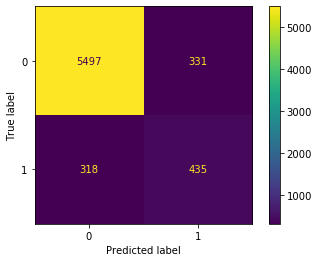

In [866]:
# Predict on test data and evaluate results
xgbcl_predicted = xgbcl_under.predict(X_test)

cm = confusion_matrix(y_test, xgbcl_predicted, labels=xgbcl_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbcl_under.classes_)
disp.plot()


print('Precision:{0:.3f}'.format(precision_score(y_test, xgbcl_predicted)))
print('Recall:{0:.3f}'.format(recall_score(y_test, xgbcl_predicted)))
print('F1-score:{0:.3f}'.format(f1_score(y_test, xgbcl_predicted)))
print('roc_auc_score:{}'.format(roc_auc_score(y_test, xgbcl_under.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, xgbcl_under.predict_proba(X_test)[:, 1])))

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


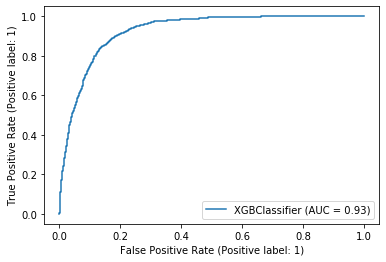

In [831]:
# Plotting ROC curve - model was fit on undersampled data
plot_roc_curve(xgbcl, X_test, y_test) 

#### Feature importance

Permutation importance

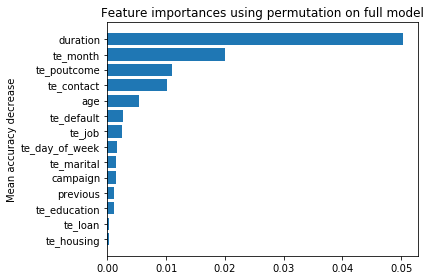

In [942]:
perm_importance = permutation_importance(xgbcl, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Shap values analysis

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


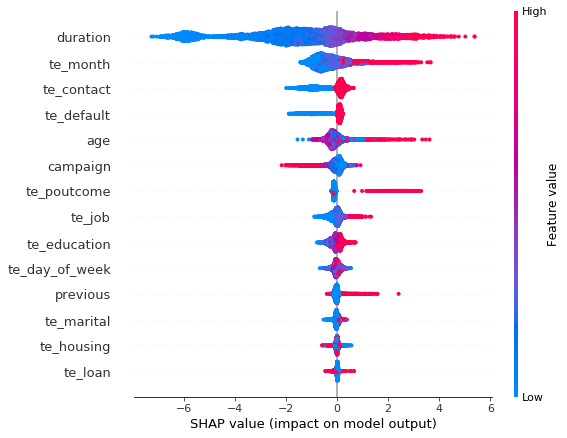

In [817]:
explainer = shap.TreeExplainer(xgbcl)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

From the two previous graphs, the most important features are: duration, te_poutcome, te_month, te_contact, age as for the random forest model.

On shap values also te_default and campaing are considered important.


## Parameter tuning on XGBoost

In [832]:
from sklearn.pipeline import Pipeline

# Define pipeline steps (in this case only one)
steps = [('xgb_model', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False))]
xgb_pipeline = Pipeline(steps)

# Create the parameter grid
param_grid = {
    'xgb_model__max_depth': np.arange(1, 6, 1),
    'xgb_model__min_child_weight': np.arange(1,6,1),
    'xgb_model__n_estimators': np.arange(50, 200, 50),
    'xgb_model__eta': [.3, .2, .1, .05, .01]
    
}

# Instantiate GridSearchCV
randomized_roc_auc = GridSearchCV(xgb_pipeline, param_grid,
                                        scoring='roc_auc', cv=3, verbose=1)

# Fit the estimator
randomized_roc_auc.fit(X, y)

print('Score: ', randomized_roc_auc.best_score_)
print('Estimator: ', randomized_roc_auc.best_estimator_)

Fitting 3 folds for each of 375 candidates, totalling 1125 fits
[00:47:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'

[00:47:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:47:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:48:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:48:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:48:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:48:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:49:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:49:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:49:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:49:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:49:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:50:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:50:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:50:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:50:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:51:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:51:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:51:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:51:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:52:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:52:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:52:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:52:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:52:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:53:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:53:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:53:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:53:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:54:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:54:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:54:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:54:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:54:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:55:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:55:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score:  0.9261089359875957
Estimator:  Pipeline(steps=[('xgb_model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eta=0.1, gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step

In [833]:
#Evaluate tuned model
best_xgb = randomized_roc_auc.best_estimator_
best_predictions = best_xgb.predict(X_test)

print('roc_auc_score:{}'.format(roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, best_xgb.predict_proba(X_test)[:, 1])))

roc_auc_score:0.9288458155481483
pr_auc_score:0.5985110979463282


XGBoost has an internal parameter to deal with class imbalance: "scale_pos_weight". This parameter could be tuned to check if it is possible to improve the score.

### Lift analysis on XGBoost

In [834]:
predictions = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(xgbcl_under.predict_proba(X_test)[:, 1], columns=['y_pred_proba']).reset_index(drop=True), pd.DataFrame(xgbcl_predicted, columns=['y_pred']).reset_index(drop=True)], axis=1).sort_values(by="y_pred_proba", ascending=False)
predictions['buckets'] = pd.qcut(predictions['y_pred_proba'], 10, labels=range(1,11))

avg_subscription_rate = len(predictions[predictions['y']==1])/len(predictions)

for i in range(1,11):
    predicted_subscription_rate = len(predictions[(predictions['y']==1) & (predictions['buckets']==i)])/len(predictions[(predictions['buckets']==i)])
    print("decile: "+str(i), end=" - ")
    print("lift score: "+str(predicted_subscription_rate/avg_subscription_rate))


decile: 1 - lift score: 0.0
decile: 2 - lift score: 0.0
decile: 3 - lift score: 0.013282230752774111
decile: 4 - lift score: 0.03984669225832233
decile: 5 - lift score: 0.06641115376387056
decile: 6 - lift score: 0.18595123053883755
decile: 7 - lift score: 0.41174915333599743
decile: 8 - lift score: 1.3282230752774111
decile: 9 - lift score: 2.7228573043186928
decile: 10 - lift score: 5.233198916593


As seen in the previous cells, the lift score indicates that if the 10th decile (the one with highest probbility to subscribe) is taken into account to perform a certain action, we would have more than 5 times chances to perform the action on a subscriber compared to taking random clients.

## Modelling and eval - Nerual Networks

In [835]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=100, random_state=42)
clf.fit(X, y)

MLPClassifier(max_iter=100, random_state=42)

In [909]:
MLPpredictions = clf.predict(X_test)

roc_auc_score:0.9036473643290028
pr_auc_score:0.5426744906391731


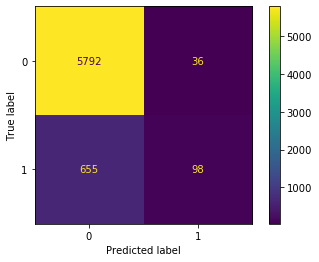

In [837]:
cm = confusion_matrix(y_test, MLPpredictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()


print('roc_auc_score:{}'.format(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])))

### Parameter tuning on Neural network to improve poor performance

In [838]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=3)
clf.fit(X, y)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [839]:
# Best parameters set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.899 (+/-0.009) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.890 (+/-0.006) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.899 (+/-0.009) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.903 (+/-0.009) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver':

In [840]:
MLPpredictions_tuned = clf.predict(X_test)

roc_auc_score:0.9172358837357046
pr_auc_score:0.5877214198210089


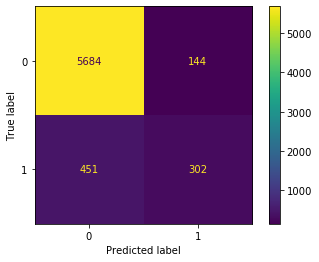

In [841]:
cm = confusion_matrix(y_test, MLPpredictions_tuned, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()


print('roc_auc_score:{}'.format(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
print('pr_auc_score:{}'.format(average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])))

## Prediction on test dataset

In [891]:
best_rf = grid_search

In [928]:
pd.DataFrame(np.around(best_rf.predict_proba(df_test_te)[:, 1], decimals=6)).to_csv('random_forest_predictions.csv', index=False)

## Conclusions

#### Introduction

The provided dataset consists of 15 columns: 14 features and 1 target.

The features are mostly categorical (10) and contained specific information about people interviewed during phone calls. These phone calls were part of a marketing campaign used to assess if a product would be subscribed by a client.

#### Data preparation and EDA

Data did not show mistakes or particular outliers to be removed.

Numerical features are left as-is, because scaling them did not improve the score metrics of the model. On the other side, target encoding is performed on categorical features. In this case it was important to execute target encoding after train-test split to avoid possible data leakage, so the mean of the target of the training set is used to encode also validation and test set.

Correlation matrix after target encoding shows that "duration" is the feature which is most correlated with the target, while  there is strong correlation between "previous" and "te_poutcome". Removing some correlated features did not improve the score of the model.

The target is imbalanced, indicating that most of the clients did not subscribe. In particular only around 11% of the records had a positive target, out of the whole training set.
In order to deal with this problem, target dataset is rebalanced with a factor of 15%. Different experiments showed that rebalancing did not improve the score on all the models, only on Random Forest.

#### Models implementation and evaluation

Three models were compared and evaluated without parameter tuning:

- Random Forest:
    - roc_auc_score (without rebalance): 0.9250
    - roc_auc_score (with rebalance): 0.9263
    
- Logistic Regression:
    - roc_auc_score (without rebalance): 0.9165
    - roc_auc_score (with rebalance): 0.9165

- XGBoost:
    - roc_auc_score (without rebalance): 0.9250
    - roc_auc_score (with rebalance): 0.9226

Random forest and XGBoost appear to have better scores compared to Logistic regression so they were both optimezed. Random forest increased performance on rebalanced dataset.

Evaluation after optimizazion:

- Random Forest (on rebalanced training set)
    - roc_auc_score: 0.9306
    - pr_auc_score: 0.6168
    
- XGBoost (on original training set)
    - roc_auc_score: 0.9288
    - pr_auc_score: 0.5426

After parameters tuning, the model with highest performance appears to be the Random Forest despite also XGBoost has high predictive capacity on the target. Note: pr_auc_score is not computed as area under pr curve but with an approximation using average_precision_score.

Using tuned xgboost model, lift score was implemented. it is interesting to notice that this score indicates that if the 10th decile (the one with highest probbility to subscribe) is taken into account to perform a certain marketing action, we would have more than 5 times chances to perform the action on a subscriber compared to taking random clients.

#### Deep learning implementation

A test was performed also using Neural networks: the base model showed poorer performance compared to the other models; the performance increased after parameter tuning but did not overperform Random Forest or XGBoost.

- before parameters tuning - roc_auc_score: 0.9036

- after parameters tuning - roc_auc_score: 0.9172

#### Feature importance

The independent features which were most impactful on the target are duration, te_poutcome, te_month, te_contact, age.
In particulare from the shap values analysis it is possible to say that high values of duration or age correspond to a positive target. 
Also, higher value of te_contact and te_month, so "cellular" or months like "october" or "december", rise the model's propensity to predict a positive target.

#### Final outcome

Random forest was finally used to predict the target values on the test dataset. Out of 40 records, 4 appear to have the highest probability to be a subscriber, using 0,48 as a probability threshold.

#### Possible next steps

A better parameter tuning could be done on neural network as there was a good improvement on the metric, despite not being enough to overperform the other models.
New features could be engineered and a feature selection algorithm like PCA could be tried to check if performance of some models could be improved even more.